# Evaluate Ensemble

This notebook combines the classification results of some models via logit-ensembling way.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
import sys
import pickle
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

import pprint
import wandb
import matplotlib
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.evaluate import calculate_confusion_matrix
from train.evaluate import calculate_class_wise_metrics
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion, draw_confusion2
from train.visualize import draw_class_wise_metrics
from train.visualize import draw_error_table
from train.visualize import annotate_heatmap

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.12.1+cu113
cuda is available.


-----

## List up the models to check accuracy

In [4]:
model_names = [
    'lo88puq7',  # 2D-VGG-19
    '2s1700lg',  # 1D-ResNet-18 
    'v301o425',  # 1D-ResNeXt-50 
    '1sl7ipca',  # 2D-ResNeXt-50 
    'gvqyvmrj',  # 1D-ResNet-50 
    'gjkysllw',  # 2D-ViT-B-16 
    'xci5svkl',  # 2D-ResNet-18 
    '1vc80n1f',  # 1D-VGG-19 
    'syrx7bmk',  # 2D-ResNet-50 
]

model_pool = []

for model_name in model_names:
    path = os.path.join(r'./local\checkpoint', model_name, 'checkpoint.pt')
    try:
        ckpt = torch.load(path, map_location=device)
        print(ckpt['config']['model'])
        model_pool.append({'name': model_name, 'path': path})
    except Exception as e:
        print(e)
        print(f'- checkpoint cannot be opened: {path}')
        
pprint.pprint([model_dict['name'] for model_dict in model_pool])

2D-VGG-19
1D-ResNet-18
1D-ResNeXt-50
2D-ResNeXt-50
1D-ResNet-50
2D-ViT-B-16
2D-ResNet-18
1D-VGG-19
2D-ResNet-50
['lo88puq7',
 '2s1700lg',
 'v301o425',
 '1sl7ipca',
 'gvqyvmrj',
 'gjkysllw',
 'xci5svkl',
 '1vc80n1f',
 'syrx7bmk']


---

## Configurations

In [5]:
base_repeat = 800
crop_multiple = 8
test_crop_multiple = 8
verbose = False
save_fig = False
task = 'exp-dementia'

eval_train = True
eval_val = True
eval_test = True
eval_test_multi = True

-----

## Evaluate each model and accumulate the logits

In [6]:
for model_dict in model_pool:
    # load and parse the checkpoint
    ckpt = torch.load(model_dict['path'], map_location=device)
    model_state = ckpt['model_state']
    config = ckpt['config']
    
    model_dict['model'] = config['model']
    model_dict['num_params'] = config.get('num_params', '???')
    model_dict['model size (MiB)'] = sys.getsizeof(pickle.dumps(model_state)) / (1024 * 1024)
    
    if '220419' in config['dataset_path']:
        config['dataset_path'] = './local/dataset/caueeg-dataset/'
    config['run_mode'] = 'eval'
    
    model_dict['seq_length'] = config['seq_length']
    model_dict['use_age'] = config['use_age']
    model_dict['photic'] = config['photic']
    model_dict['EKG'] = config['EKG']

    model_dict['awgn'] = config.get('awgn', 0)
    model_dict['awgn_age'] = config.get('awgn_age', 0)
    model_dict['mgn'] = config.get('mgn', 0)
    model_dict['mixup'] = config.get('mixup', 0)
    model_dict['dropout'] = config.get('dropout', 0)
    model_dict['weight_decay'] = config.get('weight_decay', '???')
    model_dict['fc_stages'] = config.get('fc_stages', 1)
    model_dict['activation'] = config.get('activation', 0)

    model_dict['minibatch'] = round(config['minibatch'])
    model_dict['total_samples'] = round(config.get('total_samples', config['iterations'] * config['minibatch']))
    model_dict['base_lr'] = config.get('base_lr', config.get('LR', '???'))
    model_dict['lr_scheduler_type'] = config.get('lr_scheduler_type', 'constant_with_decay')
    model_dict['warmup_steps'] = config.get('warmup_steps', '???')
    model_dict['seed'] = config.get('seed', '???')
    
    print('- checking for', model_dict['name'], config['model'], '...')
    
    # initiate the model
    if '_target_' in config:
        model = hydra.utils.instantiate(config).to(device)
    elif type(config['generator']) is str:
        config['generator'] = getattr(models, config['generator'].split('.')[-1])
        if 'block' in config:
            config['block'] = getattr(models, config['block'].split('.')[-1])
        model = config['generator'](**config).to(device)
    else:
        if 'block' in config:
            if config['block'] == models.resnet_1d.BottleneckBlock1D:
                config['block'] = 'bottleneck'
            elif config['block'] == models.resnet_2d.Bottleneck2D:
                config['block'] = 'bottleneck'
            elif config['block'] == models.resnet_1d.BasicBlock1D:
                config['block'] = 'basic'
            elif config['block'] == models.resnet_2d.BasicBlock2D:
                config['block'] = 'basic'
                
        model = config['generator'](**config).to(device)
    
    if config.get('ddp', False):
        model_state_ddp = deepcopy(model_state)
        model_state = OrderedDict()
        for k, v in model_state_ddp.items():
            name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
            model_state[name] = v
    
    model.load_state_dict(model_state)
    
    # reconfigure and update
    config.pop('cwd', 0)
    config['ddp'] = False
    config['crop_multiple'] = crop_multiple
    config['test_crop_multiple'] = test_crop_multiple
    config['crop_timing_analysis'] = False
    config['eval'] = True
    config['device'] = device
    
    repeat = round(base_repeat / crop_multiple)
    model_dict['repeat'] = repeat
    model_dict['crop_multiple'] = crop_multiple
    model_dict['test_crop_multiple'] = test_crop_multiple
    
    # build dataset
    _ = build_dataset_for_train(config, verbose=verbose)
    train_loader = _[0]
    val_loader = _[1]
    test_loader = _[2]
    multicrop_test_loader = _[3]
    
    # train accuracy
    if eval_train:
        train_acc = check_accuracy(model, train_loader, 
                                   config['preprocess_test'], config, repeat=repeat)
        model_dict['Train Accuracy'] = train_acc
    
    # val accuracy
    if eval_val:
        val_acc = check_accuracy(model, val_loader, 
                                 config['preprocess_test'], config, repeat=repeat)
        model_dict['Validation Accuracy'] = val_acc
    
    # Test accuracy
    if eval_test:
        _ = check_accuracy_extended(model, test_loader, 
                                    config['preprocess_test'], config, repeat=repeat)
        model_dict['Test Throughput'] = _[4]
        model_dict['Test Accuracy'] = _[0]
        model_dict['Test Score'] = _[1]
        model_dict['Test Target'] = _[2]
        test_confusion = _[3]
        test_class_wise_metrics = calculate_class_wise_metrics(test_confusion)

        for k, v in test_class_wise_metrics.items():
            for c in range(config['out_dims']):
                c_name = config['class_label_to_name'][c]
                model_dict[f'{k} ({c_name})'] = test_class_wise_metrics[k][c]
            
        if save_fig:
            draw_roc_curve(model_dict['Test Score'], 
                           model_dict['Test Target'], 
                           config['class_label_to_name'], 
                           use_wandb=False, 
                           save_path=f'local/output/imgs/{model_dict["name"]}-ROC.pdf')

            draw_confusion(test_confusion, 
                           config['class_label_to_name'], 
                           use_wandb=False, 
                           save_path=f'local/output/imgs/{model_dict["name"]}-confusion.pdf')

            draw_class_wise_metrics(test_confusion, 
                                    config['class_label_to_name'], 
                                    use_wandb=False, 
                                    save_path=f'local/output/imgs/{model_dict["name"]}-class-wise.pdf')
    
    # Multi-crop test accuracy
    if eval_test_multi:
        _ = check_accuracy_multicrop_extended(model, multicrop_test_loader, 
                                              config['preprocess_test'], config, repeat=repeat)
        model_dict['Multi-Crop Test Throughput'] = _[4]
        model_dict['Multi-Crop Test Accuracy'] = _[0]
        model_dict['Multi-Crop Test Score'] = _[1]
        model_dict['Multi-Crop Test Target'] = _[2]
        multi_test_confusion = _[3]
        multi_test_class_wise_metrics = calculate_class_wise_metrics(multi_test_confusion)

        for k, v in multi_test_class_wise_metrics.items():
            for c in range(config['out_dims']):
                c_name = config['class_label_to_name'][c]
                model_dict[f'Multi-Crop {k} ({c_name})'] = multi_test_class_wise_metrics[k][c]

        if save_fig:
            draw_roc_curve(model_dict['Multi-Crop Test Score'], 
                           model_dict['Multi-Crop Test Target'], 
                           config['class_label_to_name'], 
                           use_wandb=False, 
                           save_path=f'local/output/imgs/{model_dict["name"]}-roc-tta.pdf')

            draw_confusion(multi_test_confusion, 
                           config['class_label_to_name'], 
                           use_wandb=False, 
                           save_path=f'local/output/imgs/{model_dict["name"]}-confusion-tta.pdf')

            draw_class_wise_metrics(multi_test_confusion, 
                                    config['class_label_to_name'], 
                                    use_wandb=False, 
                                    save_path=f'local/output/imgs/{model_dict["name"]}-class-wise-tta.pdf') 
            
print('==== Finished ====')

- checking for lo88puq7 2D-VGG-19 ...
- checking for 2s1700lg 1D-ResNet-18 ...
- checking for v301o425 1D-ResNeXt-50 ...
- checking for 1sl7ipca 2D-ResNeXt-50 ...
- checking for gvqyvmrj 1D-ResNet-50 ...
- checking for gjkysllw 2D-ViT-B-16 ...
- checking for xci5svkl 2D-ResNet-18 ...
- checking for 1vc80n1f 1D-VGG-19 ...
- checking for syrx7bmk 2D-ResNet-50 ...
==== Finished ====


## Conduct ensemble

In [7]:
if eval_test:
    ensem_test_score = np.zeros_like(model_pool[0]['Test Score'])
    ensem_test_latency = 0

if eval_test_multi:
    ensem_multi_test_score = np.zeros_like(model_pool[0]['Multi-Crop Test Score'])
    ensem_multi_test_latency = 0

ensem_params = 0
ensem_model_size = 0

for model_dict in model_pool:
    ensem_params += model_dict['num_params']
    ensem_model_size += model_dict['model size (MiB)']

    if eval_test:
        ensem_test_score += model_dict['Test Score'] / len(model_pool)
        ensem_test_latency += 1 / model_dict['Test Throughput']
        
    if eval_test_multi:
        ensem_multi_test_score += model_dict['Multi-Crop Test Score'] / len(model_pool)
        ensem_multi_test_latency += 1 / model_dict['Multi-Crop Test Throughput']

In [14]:
# test accuracy
if eval_test:
    N = ensem_test_score.shape[0] // base_repeat
    pred_ = ensem_test_score.argmax(axis=-1)
    target_ = model_pool[0]['Test Target']
    ensem_test_acc = 100.0 * (pred_.squeeze() == target_).sum() / pred_.shape[0]

    # confusion matrix
    ensem_test_confusion = []
    for i in range(base_repeat):
        pred = pred_[i*N:(i + 1)*N]
        target = target_[i*N:(i + 1)*N]
        ensem_test_confusion.append(calculate_confusion_matrix(pred, target, 
                                                                  num_classes=ensem_test_score.shape[-1]))
    ensem_test_confusion = np.array(ensem_test_confusion)
    ensem_test_class_wise_metrics = calculate_class_wise_metrics(ensem_test_confusion.sum(axis=0))
    
    # draw
    save_path = f'local/output/imgs/{task}-ensemble-confusion.pdf' if save_fig else None
    draw_confusion(ensem_test_confusion.sum(axis=0), config['class_label_to_name'], 
                   normalize=True, use_wandb=False, save_path=save_path)

    save_path = f'local/output/imgs/{task}-ensemble-confusion2.pdf' if save_fig else None
    draw_confusion2(ensem_test_confusion.mean(axis=0), 
                    ensem_test_confusion.std(axis=0), 
                    config['class_label_to_name'], use_wandb=False, save_path=save_path)
    
    save_path = f'local/output/imgs/{task}-ensemble-roc.pdf' if save_fig else None
    draw_roc_curve(ensem_test_score, model_pool[0]['Test Target'], config['class_label_to_name'], 
                   use_wandb=False, save_path=save_path)

    save_path = f'local/output/imgs/{task}-ensemble-class-wise.pdf' if save_fig else None
    draw_class_wise_metrics(ensem_test_confusion.sum(axis=0), config['class_label_to_name'], 
                            use_wandb=False, save_path=save_path)

KeyError: 'Test Target'

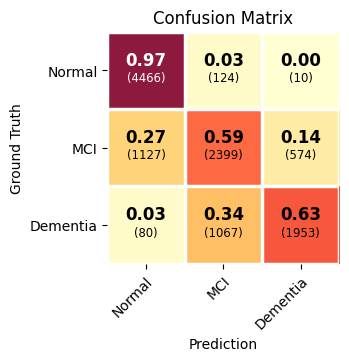

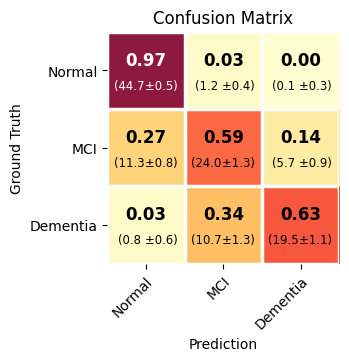

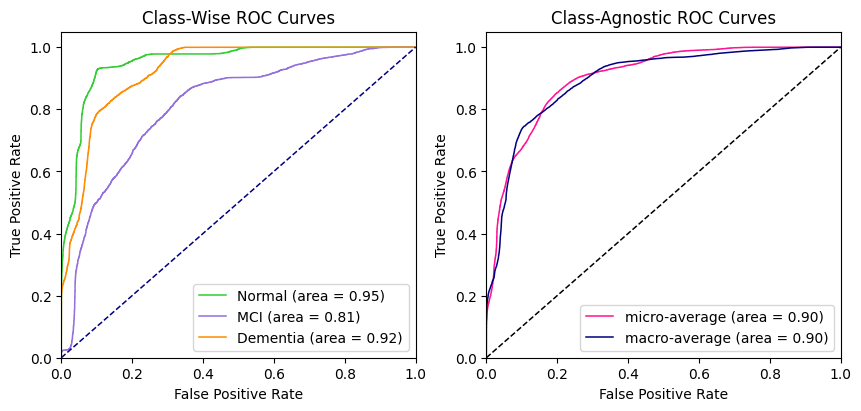

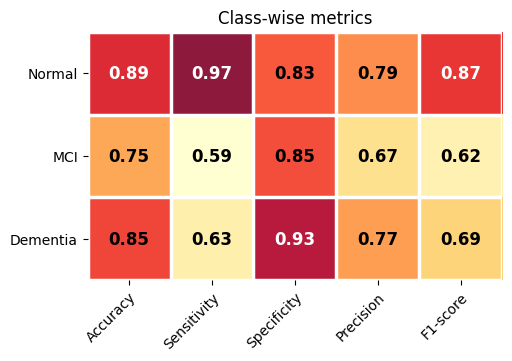

In [9]:
# multi-crop accuracy
if eval_test_multi:
    N = ensem_multi_test_score.shape[0] // (base_repeat // test_crop_multiple)
    pred_ = ensem_multi_test_score.argmax(axis=-1)
    target_ = model_pool[0]['Multi-Crop Test Target']
    ensem_multi_test_acc = 100.0 * (pred_.squeeze() == target_).sum() / pred_.shape[0]

    # confusion matrix
    ensem_multi_test_confusion = []
    for i in range((base_repeat // test_crop_multiple)):
        pred = pred_[i*N:(i + 1)*N]
        target = target_[i*N:(i + 1)*N]
        ensem_multi_test_confusion.append(calculate_confusion_matrix(pred, target, 
                                                                     num_classes=ensem_multi_test_score.shape[-1]))
    ensem_multi_test_confusion = np.array(ensem_multi_test_confusion)
    ensem_multi_test_class_wise_metrics = calculate_class_wise_metrics(ensem_multi_test_confusion.sum(axis=0))
    
    # draw
    save_path = f'local/output/imgs/{task}-ensemble-confusion-tta.pdf' if save_fig else None
    draw_confusion(ensem_multi_test_confusion.sum(axis=0), config['class_label_to_name'], 
                   normalize=True, use_wandb=False, save_path=save_path)

    save_path = f'local/output/imgs/{task}-ensemble-confusion-tta2.pdf' if save_fig else None
    draw_confusion2(ensem_multi_test_confusion.mean(axis=0), 
                    ensem_multi_test_confusion.std(axis=0), 
                    config['class_label_to_name'], use_wandb=False, save_path=save_path)
    
    save_path = f'local/output/imgs/{task}-ensemble-roc-tta.pdf' if save_fig else None
    draw_roc_curve(ensem_multi_test_score, model_pool[0]['Multi-Crop Test Target'], config['class_label_to_name'], 
                   use_wandb=False, save_path=save_path)

    save_path = f'local/output/imgs/{task}-ensemble-class-wise-tta.pdf' if save_fig else None
    draw_class_wise_metrics(ensem_multi_test_confusion.sum(axis=0), config['class_label_to_name'], 
                            use_wandb=False, save_path=save_path)

## Summarize the ensemble results

In [10]:
ensem_dict = {}

ensem_dict['name'] = 'Ensemble'
ensem_dict['num_params'] = ensem_params
ensem_dict['model size (MiB)'] = ensem_model_size

if eval_test:
    ensem_dict['Test Throughput'] = 1 / ensem_test_latency
    ensem_dict['Test Accuracy'] = ensem_test_acc
    
    for k, v in ensem_test_class_wise_metrics.items():
        for c in range(config['out_dims']):
            c_name = config['class_label_to_name'][c]
            ensem_dict[f'{k} ({c_name})'] = ensem_test_class_wise_metrics[k][c]

if eval_test_multi:
    ensem_dict['Multi-Crop Test Throughput'] = 1 / ensem_multi_test_latency
    ensem_dict['Multi-Crop Test Accuracy'] = ensem_multi_test_acc
        
    for k, v in ensem_multi_test_class_wise_metrics.items():
        for c in range(config['out_dims']):
            c_name = config['class_label_to_name'][c]
            ensem_dict[f'Multi-Crop {k} ({c_name})'] = ensem_multi_test_class_wise_metrics[k][c]
        
model_pool.append(ensem_dict)

In [11]:
for model_dict in model_pool:
    model_dict.pop('Test Score', None)
    model_dict.pop('Test Target', None)
    model_dict.pop('Multi-Crop Test Score', None)
    model_dict.pop('Multi-Crop Test Target', None)

In [12]:
pd.DataFrame(model_pool)

,name,path,model,num_params,model size (MiB),seq_length,use_age,photic,EKG,awgn,...,Multi-Crop Sensitivity (Dementia),Multi-Crop Specificity (Normal),Multi-Crop Specificity (MCI),Multi-Crop Specificity (Dementia),Multi-Crop Precision (Normal),Multi-Crop Precision (MCI),Multi-Crop Precision (Dementia),Multi-Crop F1-score (Normal),Multi-Crop F1-score (MCI),Multi-Crop F1-score (Dementia)
0,lo88puq7,./local\checkpoint\lo88puq7\checkpoint.pt,2D-VGG-19,20184131,77.073749,4000.0,conv,X,O,0.047940,...,0.437742,0.788889,0.774675,0.969310,0.736568,0.606219,0.835591,0.819672,0.628027,0.574513
1,2s1700lg,./local\checkpoint\2s1700lg\checkpoint.pt,1D-ResNet-18,11394051,43.550922,2000.0,conv,O,O,0.000000,...,0.612903,0.823472,0.824805,0.881034,0.760008,0.622023,0.647359,0.813460,0.578954,0.629660
2,v301o425,./local\checkpoint\v301o425\checkpoint.pt,1D-ResNeXt-50,25650051,98.227805,4000.0,fc,X,O,0.037536,...,0.624516,0.922500,0.737273,0.868161,0.859869,0.572756,0.627960,0.797949,0.613922,0.626233
3,1sl7ipca,./local\checkpoint\1sl7ipca\checkpoint.pt,2D-ResNeXt-50,25886467,99.136700,4000.0,fc,O,X,0.103950,...,0.531935,0.772778,0.809351,0.917701,0.721769,0.587060,0.697252,0.809924,0.545265,0.603477
4,gvqyvmrj,./local\checkpoint\gvqyvmrj\checkpoint.pt,1D-ResNet-50,26178179,100.184862,1000.0,fc,O,X,0.012513,...,0.488710,0.762639,0.801558,0.916897,0.716113,0.568605,0.676944,0.811864,0.527087,0.567628
5,gjkysllw,./local\checkpoint\gjkysllw\checkpoint.pt,2D-ViT-B-16,90054147,343.587790,12000.0,conv,X,O,0.029602,...,0.574194,0.740556,0.867403,0.866897,0.704757,0.597239,0.605854,0.816143,0.456368,0.589599
6,xci5svkl,./local\checkpoint\xci5svkl\checkpoint.pt,2D-ResNet-18,11425155,43.664292,2000.0,fc,X,O,0.074615,...,0.416774,0.735417,0.801688,0.930345,0.690897,0.591602,0.680717,0.791229,0.564358,0.517007
7,1vc80n1f,./local\checkpoint\1vc80n1f\checkpoint.pt,1D-VGG-19,20205251,77.157111,2000.0,conv,X,O,0.008120,...,0.671290,0.865278,0.798182,0.840805,0.790768,0.579773,0.600404,0.793850,0.549885,0.633871
8,syrx7bmk,./local\checkpoint\syrx7bmk\checkpoint.pt,2D-ResNet-50,25729475,98.467559,4000.0,conv,X,O,0.002375,...,0.540000,0.779167,0.762987,0.952644,0.715767,0.557039,0.802493,0.785560,0.558394,0.645584
9,Ensemble,NaN,NaN,256706907,981.050790,NaN,NaN,NaN,NaN,NaN,...,0.630000,0.832361,0.845325,0.932874,0.787238,0.668245,0.769807,0.869464,0.623927,0.692922


In [13]:
pd.DataFrame(model_pool).to_csv(f'local/output/{task}-ensemble.csv')

##### 